# Install the Libraries

In [8]:

!pip install tiktoken
!pip install pandas matplotlib  # For visualization

In [9]:
import tiktoken
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Check library availability

In [10]:
try:
    import tiktoken
    TIKTOKEN_AVAILABLE = True
    print(" tiktoken available - Can use GPT-4/GPT-3.5 tokenizers")
except ImportError:
    TIKTOKEN_AVAILABLE = False
    print(" tiktoken not available")

 tiktoken available - Can use GPT-4/GPT-3.5 tokenizers


 # Define the Tokenizer Class

In [4]:
class GPTTokenizerNotebook:
    def __init__(self, tokenizer_type="gpt-4"):
        """
        Initialize the tokenizer

        Args:
            tokenizer_type: Either "gpt-4", "gpt-3.5-turbo", or "gpt-2"
        """
        self.tokenizer_type = tokenizer_type
        self.tokenizer = None

        if TIKTOKEN_AVAILABLE and tokenizer_type in ["gpt-4", "gpt-3.5-turbo"]:
            self.tokenizer = tiktoken.encoding_for_model(tokenizer_type)
            self.tokenizer_method = "tiktoken"

        else:
            raise ImportError("Please install either tiktoken")

        print(f" Tokenizer initialized: {self.tokenizer_method} ({self.tokenizer_type})")

    def tokenize_text(self, text: str) -> List[Tuple[str, int]]:
        """Tokenize text and return list of (token, token_id) pairs"""
        if self.tokenizer_method == "tiktoken":
            token_ids = self.tokenizer.encode(text)
            tokens = [self.tokenizer.decode([token_id]) for token_id in token_ids]
            return list(zip(tokens, token_ids))

        elif self.tokenizer_method == "transformers":
            encoded = self.tokenizer(text, return_tensors="pt", add_special_tokens=False)
            token_ids = encoded['input_ids'][0].tolist()
            tokens = self.tokenizer.convert_ids_to_tokens(token_ids)
            return list(zip(tokens, token_ids))

    def process_file(self, file_path: str) -> Dict:
        """Process a text file and return tokenization results"""
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
        except FileNotFoundError:
            raise FileNotFoundError(f"File {file_path} not found")
        except UnicodeDecodeError:
            with open(file_path, 'r', encoding='latin-1') as file:
                text = file.read()

        token_pairs = self.tokenize_text(text)

        results = {
            'file_path': file_path,
            'tokenizer_used': f"{self.tokenizer_method} ({self.tokenizer_type})",
            'original_text': text,
            'original_text_length': len(text),
            'total_tokens': len(token_pairs),
            'tokens_and_ids': token_pairs,
            'unique_tokens': len(set([token for token, _ in token_pairs])),
        }

        return results

    def display_results_table(self, results: Dict, max_rows: int = 50):
        """Display results in a nice DataFrame"""
        df = pd.DataFrame(results['tokens_and_ids'], columns=['Token', 'Token_ID'])

        # Clean tokens for display
        df['Token_Display'] = df['Token'].apply(lambda x: repr(x) if '\n' in x or '\t' in x else x)
        df['Token_Length'] = df['Token'].str.len()

        print(f" TOKENIZATION SUMMARY")
        print(f"{'='*50}")
        print(f"File: {results['file_path']}")
        print(f"Tokenizer: {results['tokenizer_used']}")
        print(f"Original text length: {results['original_text_length']} characters")
        print(f"Total tokens: {results['total_tokens']}")
        print(f"Unique tokens: {results['unique_tokens']}")
        print(f"Average token length: {df['Token_Length'].mean():.2f} characters")
        print(f"\n TOKENS TABLE (showing first {min(max_rows, len(df))} rows):")

        # Display DataFrame
        display_df = df[['Token_Display', 'Token_ID', 'Token_Length']].head(max_rows)
        display_df.columns = ['Token', 'ID', 'Length']
        display(display_df)

        if len(df) > max_rows:
            print(f"\n... and {len(df) - max_rows} more tokens")

        return df

    def plot_token_analysis(self, results: Dict):
        """Create visualizations of token analysis"""
        tokens_df = pd.DataFrame(results['tokens_and_ids'], columns=['Token', 'Token_ID'])
        tokens_df['Token_Length'] = tokens_df['Token'].str.len()

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Token length distribution
        ax1.hist(tokens_df['Token_Length'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_title('Token Length Distribution')
        ax1.set_xlabel('Token Length (characters)')
        ax1.set_ylabel('Frequency')
        ax1.grid(True, alpha=0.3)

        # Token ID distribution
        ax2.hist(tokens_df['Token_ID'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
        ax2.set_title('Token ID Distribution')
        ax2.set_xlabel('Token ID')
        ax2.set_ylabel('Frequency')
        ax2.grid(True, alpha=0.3)

        # Most frequent tokens
        token_counts = tokens_df['Token'].value_counts().head(10)
        ax3.barh(range(len(token_counts)), token_counts.values, color='orange', alpha=0.7)
        ax3.set_yticks(range(len(token_counts)))
        ax3.set_yticklabels([repr(token) if '\n' in token else token for token in token_counts.index])
        ax3.set_title('Top 10 Most Frequent Tokens')
        ax3.set_xlabel('Frequency')
        ax3.grid(True, alpha=0.3)

        # Token length vs ID scatter
        ax4.scatter(tokens_df['Token_Length'], tokens_df['Token_ID'], alpha=0.6, color='purple')
        ax4.set_title('Token Length vs Token ID')
        ax4.set_xlabel('Token Length')
        ax4.set_ylabel('Token ID')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def export_results(self, results: Dict, format_type="json"):
        """Export results to file"""
        base_name = os.path.splitext(results['file_path'])[0]

        if format_type == "json":
            output_file = f"{base_name}_tokens.json"
            with open(output_file, 'w', encoding='utf-8') as f:
                json.dump(results, f, indent=2, ensure_ascii=False)

        elif format_type == "csv":
            output_file = f"{base_name}_tokens.csv"
            df = pd.DataFrame(results['tokens_and_ids'], columns=['Token', 'Token_ID'])
            df.to_csv(output_file, index=False, encoding='utf-8')

        elif format_type == "excel":
            output_file = f"{base_name}_tokens.xlsx"
            df = pd.DataFrame(results['tokens_and_ids'], columns=['Token', 'Token_ID'])
            df.to_excel(output_file, index=False)

        print(f" Results exported to: {output_file}")
        return output_file

print(" Tokenizer class defined successfully!")


 Tokenizer class defined successfully!


# Initialize the tokenizer

In [11]:

tokenizer = GPTTokenizerNotebook('gpt-4')  # Change to 'gpt-2' if needed

 Tokenizer initialized: tiktoken (gpt-4)


# Import the Text File to tokenize the content

Processing file: /content/Quantum.txt
 TOKENIZATION SUMMARY
File: /content/Quantum.txt
Tokenizer: tiktoken (gpt-4)
Original text length: 2431 characters
Total tokens: 438
Unique tokens: 197
Average token length: 5.55 characters

📋 TOKENS TABLE (showing first 50 rows):


,Token,ID,Length
0,Quant,45320,5
1,um,372,2
2,information,2038,12
3,is,374,3
4,the,279,4
5,information,2038,12
6,of,315,3
7,the,279,4
8,state,1614,6
9,of,315,3



... and 388 more tokens


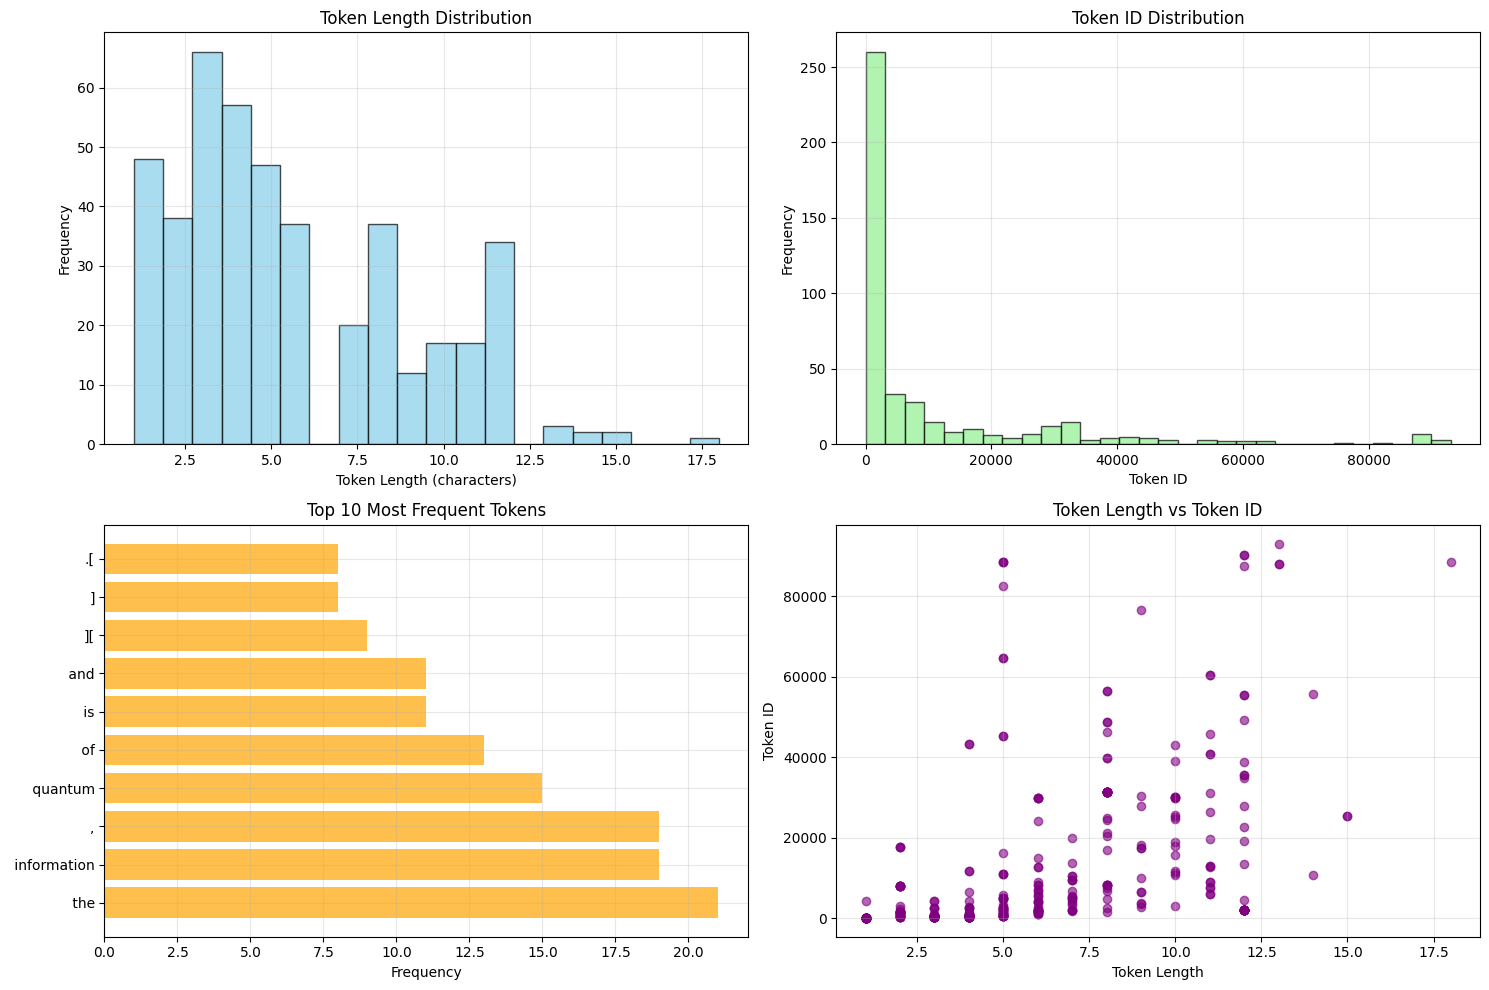

 Results exported to: /content/Quantum_tokens.csv
 Results exported to: /content/Quantum_tokens.json


In [13]:

MY_FILE_PATH = '/content/Quantum.txt'

if os.path.exists(MY_FILE_PATH):
     print(f"Processing file: {MY_FILE_PATH}")
     your_results = tokenizer.process_file(MY_FILE_PATH)
     your_df = tokenizer.display_results_table(your_results, max_rows=50)
     tokenizer.plot_token_analysis(your_results)

    # Export results
     tokenizer.export_results(your_results, "csv")
     tokenizer.export_results(your_results, "json")
else:
     print(f"File {My_FILE_PATH} not found. Please update MY_FILE_PATH variable.")
